In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, SpectralClustering, KMeans

In [6]:
#load MNIST data
num_samples = 5000
dim = 28 * 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train[:num_samples] / 255).astype(np.float32)
y_train = y_train[:num_samples]
x_train = x_train.reshape([-1, dim])
x_train.shape

(5000, 784)

In [7]:
#helper to show arrays of images
def imshow(img):
    fig = plt.figure(figsize=(20, 15))
    img = img.reshape([-1, 28, 28])
    out = np.empty([0, 280])
    for row in range((len(img) - 1) // 10 + 1):
        add = np.hstack(img[row * 10: row * 10 + 10])
        add = np.hstack([add, np.zeros([28, 280 - add.shape[1]])])
        out = np.vstack([out, add])
    plt.imshow(out)

In [8]:
#encoder-decoder model
tf.reset_default_graph()
sess = tf.InteractiveSession()

bottleneck = 10

with tf.variable_scope('dnn', reuse=tf.AUTO_REUSE):
    X = tf.placeholder(tf.float32, [None, dim])
    ebs = tf.shape(X)[0]
    Y_ = X

#    A = tf.nn.relu
    A = tf.nn.sigmoid
    
    L = X
    L = tf.layers.dense(L, units=256, activation=A)
#    L = tf.layers.dense(L, units= 64, activation=A)
    L = tf.layers.dense(L, units= bottleneck, activation=A)
    Z = L
#    L = tf.layers.dense(L, units= 64, activation=A)
    L = tf.layers.dense(L, units=256, activation=A)

    Y = tf.layers.dense(L, dim, activation=A)
    LOSS = tf.losses.mean_squared_error(Y_, Y)
    TRAIN = tf.train.AdamOptimizer().minimize(LOSS)
    ACC = tf.reduce_mean(tf.cast(tf.less(tf.abs(Y_ - Y), 0.5), tf.float32))

tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [9]:
#training
num_century = 10
century_size = 100
batch_size = 32

for century in range(num_century):
    for epoch in range(century_size):
        loss_sum = 0
        batch_idx = 0
        while batch_idx <= x_train.shape[0] - batch_size:
            res = sess.run([LOSS, TRAIN], feed_dict={X:x_train[batch_idx: batch_idx + batch_size]})
            loss_sum += res[0]
            batch_idx += batch_size
    print('Loss: {}\tAccuracy: {}'.format(loss_sum, sess.run(ACC, feed_dict={X:x_train})))

Loss: 3.5160775408148766	Accuracy: 0.9751768112182617
Loss: 2.6942293727770448	Accuracy: 0.9813591837882996
Loss: 2.3472992070019245	Accuracy: 0.984322190284729
Loss: 2.1605854630470276	Accuracy: 0.9843564033508301
Loss: 2.238518581725657	Accuracy: 0.9840198755264282
Loss: 2.06267867423594	Accuracy: 0.983590841293335
Loss: 1.8243448669090867	Accuracy: 0.9873002767562866
Loss: 1.8948758002370596	Accuracy: 0.9843004941940308
Loss: 1.8274453394114971	Accuracy: 0.985806405544281
Loss: 1.8027230324223638	Accuracy: 0.9816933870315552


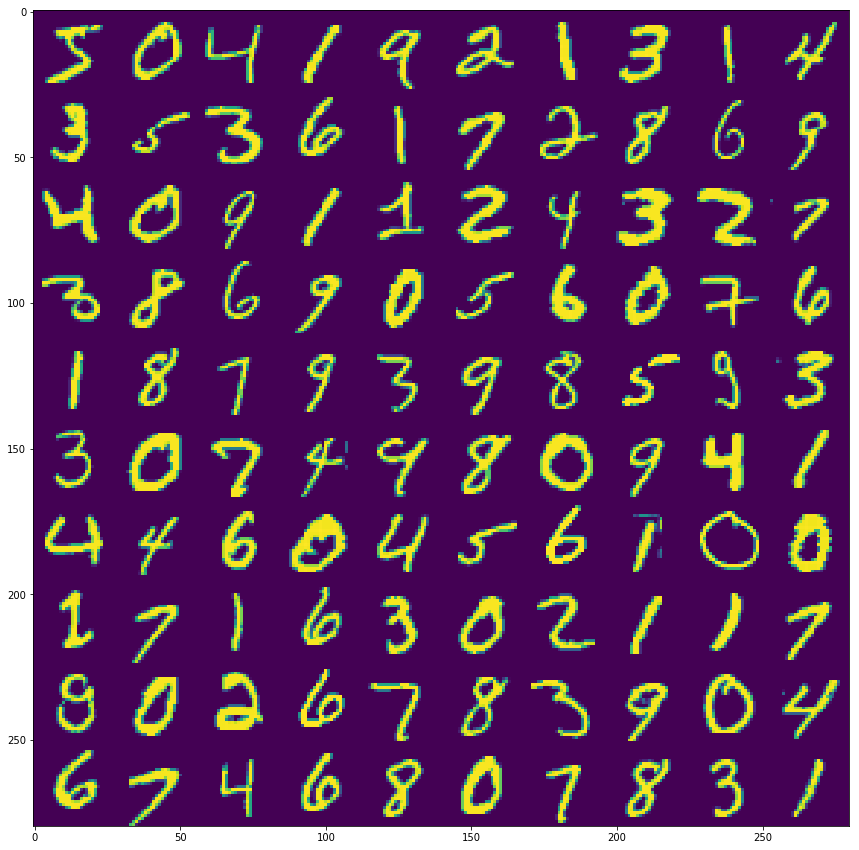

In [10]:
#input data
imshow(x_train[0:100])

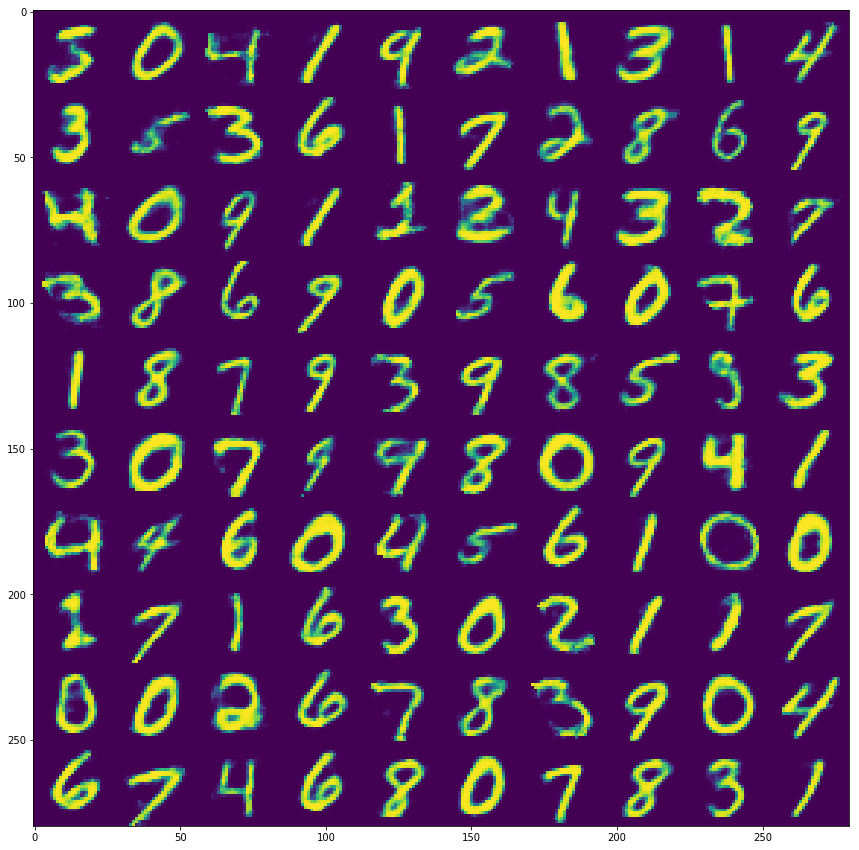

In [11]:
#output data
imshow(sess.run(Y, feed_dict={X:x_train[:100]}))

In [12]:
#clustering input data
num_clusters = 10
#cluster = SpectralClustering(num_clusters)
#cluster = KMeans(num_clusters)
#cluster = AgglomerativeClustering(num_clusters, linkage='average')
#cluster = AgglomerativeClustering(num_clusters, linkage='complete')
cluster = AgglomerativeClustering(num_clusters, linkage='ward')

res = cluster.fit_predict(x_train)

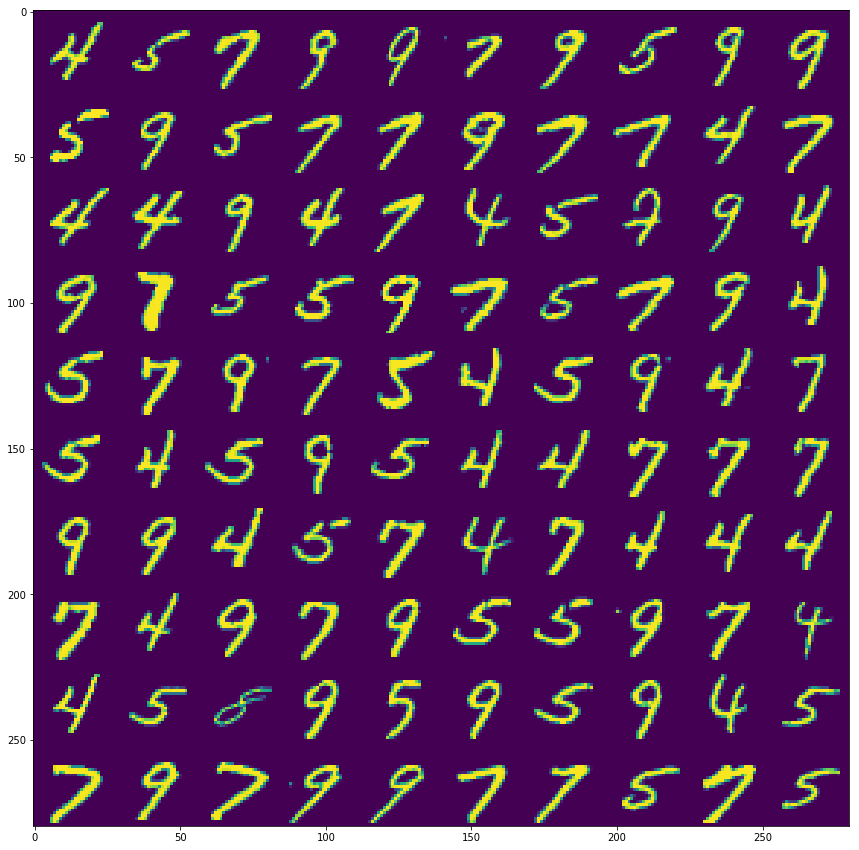

In [13]:
imshow(x_train[res == 2][:100])

In [14]:
err = np.sum([(res == c).sum() - np.bincount(y_train[res == c]).max() for c in range(num_clusters)])
print('Errors: {} of {}. Accuracy: {} on {} clusters(labeled samples).'.format(err, num_samples, (num_samples - err) / num_samples * 100, num_clusters))

Errors: 1734 of 5000. Accuracy: 65.32 on 10 clusters(labeled samples).


In [15]:
#clustering z-space (bottleneck)
res = cluster.fit_predict(sess.run(Z, feed_dict={X:x_train}))

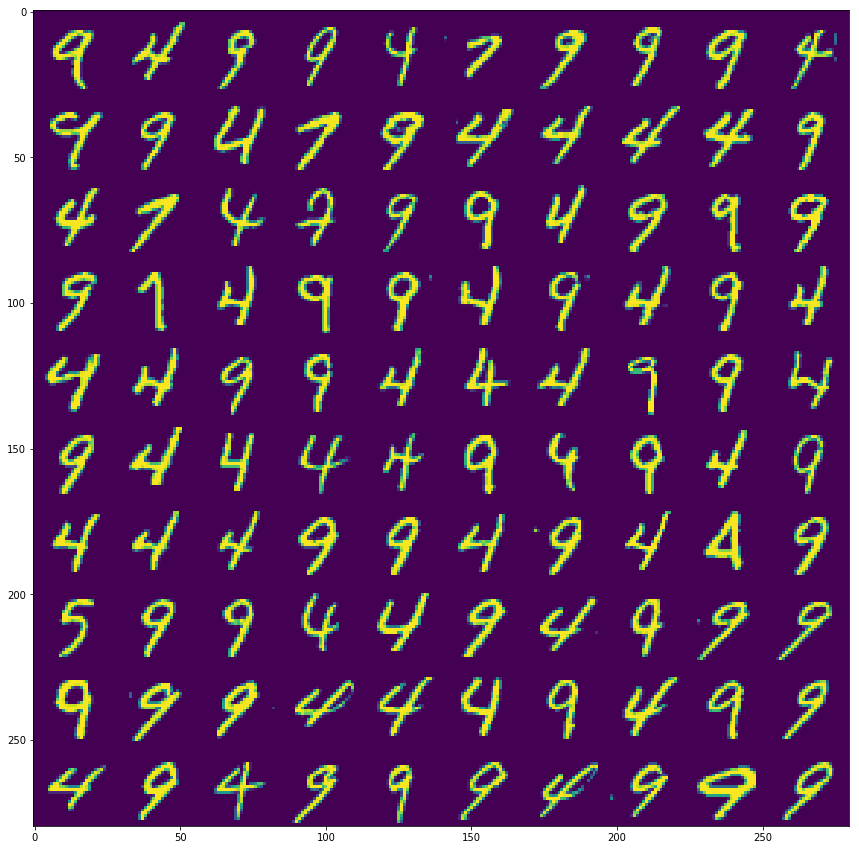

In [16]:
imshow(x_train[res == 2][:100])

In [17]:
err = np.sum([(res == clas).sum() - np.bincount(y_train[res == clas]).max() for clas in range(num_clusters)])
print('Errors: {} of {}. Accuracy: {} on {} clusters(labeled samples).'.format(err, num_samples, (num_samples - err) / num_samples * 100, num_clusters))

Errors: 1212 of 5000. Accuracy: 75.76 on 10 clusters(labeled samples).


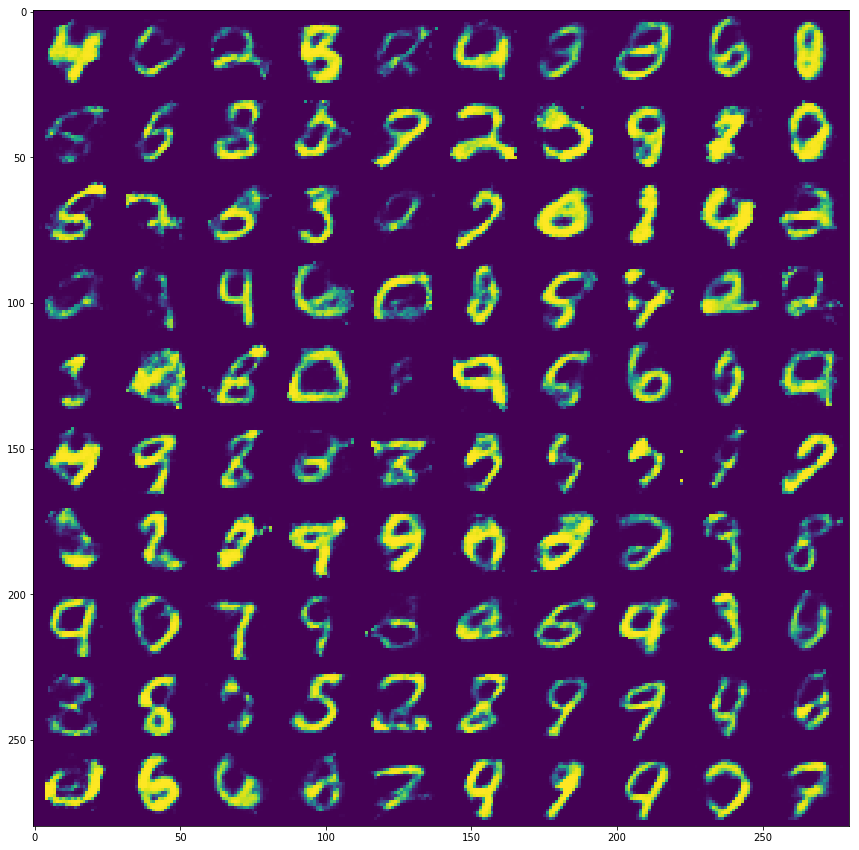

In [18]:
#random generator from z-space
imshow(sess.run(Y, feed_dict={Z: np.random.rand(100, bottleneck)}))

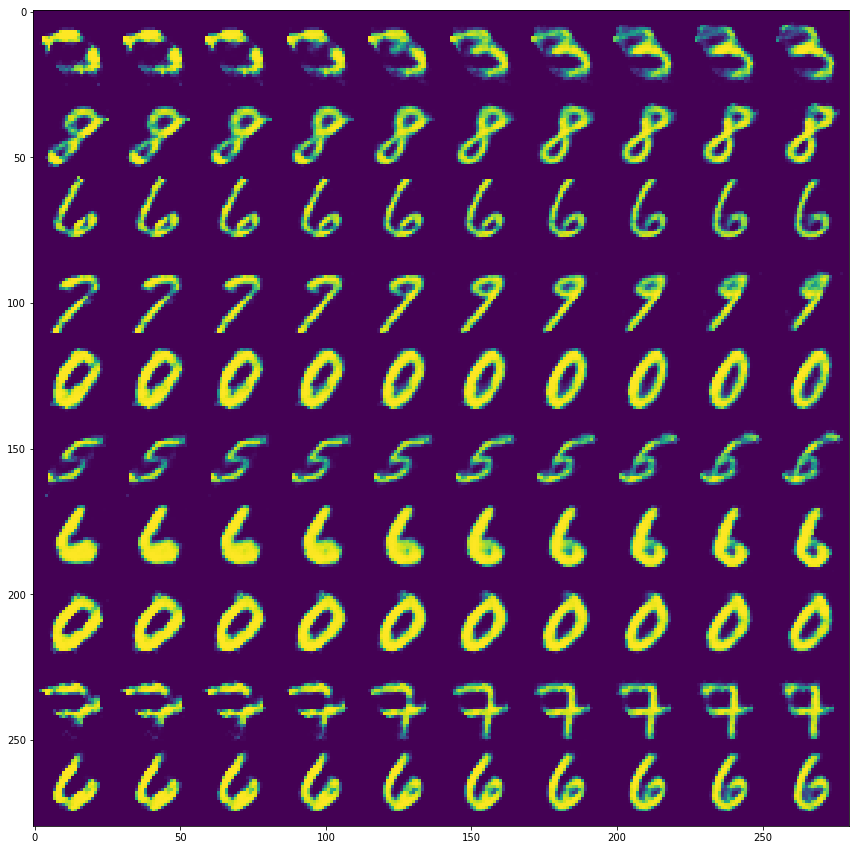

In [28]:
#feature investigation
z = sess.run(Z, feed_dict={X:x_train[30:40]})
z = np.repeat(z, 10, axis=0)
z[:, 8] += np.repeat(np.arange(-0.5, 0.5, 0.1), 10).reshape(10, 10).T.flatten()
imshow(sess.run(Y, feed_dict={Z: z}))